#notebook setup

In [1]:
!pip install google-auth --upgrade
!pip install grpcio --upgrade

     |████████████████████████████████| 81kB 2.3MB/s 
ERROR: google-colab 1.0.0 has requirement google-auth~=1.4.0, but you'll have google-auth 1.10.0 which is incompatible.
  Found existing installation: google-auth 1.4.2
    Uninstalling google-auth-1.4.2:
      Successfully uninstalled google-auth-1.4.2


     |████████████████████████████████| 2.4MB 2.8MB/s 
  Found existing installation: grpcio 1.15.0
    Uninstalling grpcio-1.15.0:
      Successfully uninstalled grpcio-1.15.0


In [2]:
!pip install -qq tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 395.5MB 40kB/s 
     |████████████████████████████████| 450kB 55.5MB/s 
     |████████████████████████████████| 3.8MB 58.9MB/s 


In [3]:
import tensorflow as tf
print(tf.__version__)
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

2.0.0-dev20191002
Found GPU at: /device:GPU:0


In [0]:
import sys
try:
    import ujson as json
except ImportError:
    try:
        import simplejson as json
    except ImportError:
        import json

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import scipy
from sklearn.preprocessing import MinMaxScaler
import pywt
import os
from PIL import Image
# import tensorflow as tf
from glob import glob

from tensorflow.keras.preprocessing import image
from tensorflow.keras.preprocessing.image import ImageDataGenerator

from tensorflow.keras.models import Model,load_model,Sequential

from tensorflow.keras.layers import Dense, GlobalAveragePooling2D, Dropout,Flatten, Input
from tensorflow.keras import backend as K
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint
import pickle

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:

def plot_hist(input_history, filename):
  import os

  folder = ['acc', 'loss']

  directory = cwd + '/model_performance/'

  for f in folder:
    if not os.path.exists(directory + f):
      os.makedirs(directory + f)

  # summarize history for accuracy
  # fig, ax = plt.subplots(1,2)
  # plt.subplots_adjust(right=2)

  plt.plot(input_history.history['accuracy'])
  plt.plot(input_history.history['val_accuracy'])
  plt.title('model accuracy')
  plt.ylabel('accuracy')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  plt.savefig(cwd+'/model_performance/acc/' + filename + '.jpg')
  plt.show()
  
  # summarize history for loss
  plt.plot(input_history.history['loss'])
  plt.plot(input_history.history['val_loss'])
  plt.title('model loss')
  plt.ylabel('loss')
  plt.xlabel('epoch')
  plt.legend(['train', 'test'], loc='upper left')

  
  plt.savefig(cwd+'/model_performance/loss/' + filename + '.jpg')

# Data prep

In [7]:
%cd drive/'My Drive/lhc_durham'
!pwd

/content/drive/My Drive/lhc_durham
/content/drive/My Drive/lhc_durham


In [8]:
img_folder = '/filtered_images'
!ls 'filtered_images'

0  1  2


class 0 : DYjets
class 1 : TTjets
class 2 : Wjets

## Train val size setting

In [9]:
cwd = os.getcwd()
img_path = cwd + img_folder

train_val_size = 1200

df = {}
data = []
for idx, x in enumerate(os.listdir(img_path)):
  if x.isdigit() and idx < 3:
    for idx2, pic in enumerate(os.listdir(img_path+'/'+str(x))):
      if idx2 < train_val_size:
        data.append((img_path+ '/' + x + '/' + pic , x))

df = pd.DataFrame(data, columns=['filename', 'class'])
df['class'] = df['class'].astype(int)
#shuffle
df = df.sample(frac=1).reset_index(drop=True)

print(df.head())
print(len(df))
df.dtypes

                                            filename  class
0  /content/drive/My Drive/lhc_durham/filtered_im...      0
1  /content/drive/My Drive/lhc_durham/filtered_im...      2
2  /content/drive/My Drive/lhc_durham/filtered_im...      1
3  /content/drive/My Drive/lhc_durham/filtered_im...      0
4  /content/drive/My Drive/lhc_durham/filtered_im...      0
3600


filename    object
class        int64
dtype: object

In [10]:
from collections import Counter
cnt = Counter(df['class'])
cnt

Counter({0: 1200, 1: 1200, 2: 1200})

In [11]:
# Split into train and validation sets
train_percentage = .8
val_percentage = 0.1
test_percentage = 0.1

train_length = int(len(df) * train_percentage)
df_train = df[:train_length]

val_length = int(len(df) * val_percentage)
df_val = df[train_length : train_length+val_length]

test_length = int(len(df) * test_percentage)
df_test = df[ train_length + val_length : ]

# shuffle 
df_train = df_train.sample(frac=1).reset_index(drop=True)
df_val = df_val.sample(frac=1).reset_index(drop=True)
df_test = df_test.sample(frac=1).reset_index(drop=True)

df_list = [df_train, df_val, df_test]
for df_part in df_list:
  print(len(df_part))

2880
360
360


#### image parsing

In [0]:
# Reads an image from a file, decodes it into a tensor, and resizes it
# to a fixed shape.
img_rows, img_cols = 200,200
num_classes = len(set(df['class']))
batch_size = 120

def _parse_function(filename, label):
  image_string = tf.io.read_file(filename)
  image_decoded = tf.image.decode_jpeg(image_string)
  image_resized = tf.image.resize(image_decoded, [img_rows, img_cols])
  image_resized = tf.ensure_shape(image_resized ,shape=(img_rows, img_cols,3))
  label = tf.one_hot(label, num_classes)
  return image_resized, label

In [0]:
train_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_train['filename'].values, tf.string),
                                                    tf.cast(df_train['class'].values, tf.int32) ))
train_dataset = train_dataset.map(_parse_function)
train_dataset = train_dataset.shuffle(5000)
train_dataset = train_dataset.repeat()
train_dataset = train_dataset.batch(batch_size, drop_remainder=True)

In [0]:
valid_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_val['filename'].values, tf.string),
                                                    tf.cast(df_val['class'].values, tf.int32) ))
valid_dataset = valid_dataset.map(_parse_function)
valid_dataset = valid_dataset.shuffle(5000)
valid_dataset = valid_dataset.repeat()
valid_dataset = valid_dataset.batch(batch_size, drop_remainder=True)

In [0]:
test_dataset = tf.data.Dataset.from_tensor_slices((tf.cast(df_test['filename'].values, tf.string),
                                                    tf.cast(df_test['class'].values, tf.int32) ))
test_dataset = test_dataset.map(_parse_function)
test_dataset = test_dataset.shuffle(5000)
test_dataset = test_dataset.repeat()
test_dataset = test_dataset.batch(batch_size, drop_remainder=True)

In [16]:
train_dataset

<BatchDataset shapes: ((120, 200, 200, 3), (120, 3)), types: (tf.float32, tf.float32)>

# InceptionV3

## Entirely frozen

In [17]:
base_incepres = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

219062272/219055592 [==============================] - 14s 0us/step


In [0]:
# add a global spatial average pooling layer
x = base_incepres.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

In [0]:
# this is the model we will train
base_incepres_model = Model(inputs=base_incepres.input, outputs=predictions)

In [20]:
for layer in base_incepres.layers:
    print(layer.name)
    layer.trainable = False

input_1
conv2d
batch_normalization
activation
conv2d_1
batch_normalization_1
activation_1
conv2d_2
batch_normalization_2
activation_2
max_pooling2d
conv2d_3
batch_normalization_3
activation_3
conv2d_4
batch_normalization_4
activation_4
max_pooling2d_1
conv2d_8
batch_normalization_8
activation_8
conv2d_6
conv2d_9
batch_normalization_6
batch_normalization_9
activation_6
activation_9
average_pooling2d
conv2d_5
conv2d_7
conv2d_10
conv2d_11
batch_normalization_5
batch_normalization_7
batch_normalization_10
batch_normalization_11
activation_5
activation_7
activation_10
activation_11
mixed_5b
conv2d_15
batch_normalization_15
activation_15
conv2d_13
conv2d_16
batch_normalization_13
batch_normalization_16
activation_13
activation_16
conv2d_12
conv2d_14
conv2d_17
batch_normalization_12
batch_normalization_14
batch_normalization_17
activation_12
activation_14
activation_17
block35_1_mixed
block35_1_conv
block35_1
block35_1_ac
conv2d_21
batch_normalization_21
activation_21
conv2d_19
conv2d_22
batc

In [21]:
for layer in base_incepres_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_1  Trainable = False
conv2d  Trainable = False
batch_normalization  Trainable = False
activation  Trainable = False
conv2d_1  Trainable = False
batch_normalization_1  Trainable = False
activation_1  Trainable = False
conv2d_2  Trainable = False
batch_normalization_2  Trainable = False
activation_2  Trainable = False
max_pooling2d  Trainable = False
conv2d_3  Trainable = False
batch_normalization_3  Trainable = False
activation_3  Trainable = False
conv2d_4  Trainable = False
batch_normalization_4  Trainable = False
activation_4  Trainable = False
max_pooling2d_1  Trainable = False
conv2d_8  Trainable = False
batch_normalization_8  Trainable = False
activation_8  Trainable = False
conv2d_6  Trainable = False
conv2d_9  Trainable = False
batch_normalization_6  Trainable = False
batch_normalization_9  Trainable = False
activation_6  Trainable = False
activation_9  Trainable = False
average_pooling2d  Trainable = False
conv2d_5  Trainable = False
conv2d_7  Trainable = False
conv2d_10 

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
base_incepres_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [23]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)
epochs = 50

#es = EarlyStopping(monitor='accuracy', mode='max', verbose=1, patience=15)

incepres_model_filepath = 'entirely_frozen_incepres_rms.h5'
mcp = ModelCheckpoint(incepres_model_filepath, monitor='accuracy', save_best_only=True, mode='max')

### Train the model with validation 
entirely_frozen_incepres_history = base_incepres_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks= [#es, 
                               mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 2204s 92s/step - loss: 0.8403 - accuracy: 0.5931 - val_loss: 1419.7559 - val_accuracy: 0.3722
Epoch 2/50
24/24 [==============================] - 16s 667ms/step - loss: 0.6893 - accuracy: 0.6747 - val_loss: 775.6961 - val_accuracy: 0.3722
Epoch 3/50
24/24 [==============================] - 17s 718ms/step - loss: 0.6560 - accuracy: 0.6997 - val_loss: 1345.6194 - val_accuracy: 0.3722
Epoch 4/50
24/24 [==============================] - 16s 655ms/step - loss: 0.6370 - accuracy: 0.7000 - val_loss: 1625.7268 - val_accuracy: 0.3722
Epoch 5/50
24/24 [==============================] - 16s 653ms/step - loss: 0.6195 - accuracy: 0.7167 - val_loss: 1441.8634 - val_accuracy: 0.3722
Epoch 6/50
24/24 [==============================] - 16s 655ms/step - loss: 0.6085 - accuracy: 0.7236 - val_loss: 1461.6566 - val_accuracy: 0.3722
Epoch 7/50
24/24 [==============================] - 16s

#### testing the model

In [24]:
test_steps = int(len(df_test)/batch_size)

metrics = base_incepres_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 230s 77s/step - loss: 3972.7870 - accuracy: 0.3444
model accuracy: 0.34444445


#### plotting training

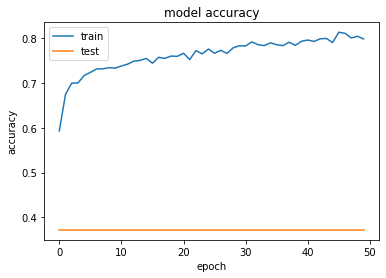

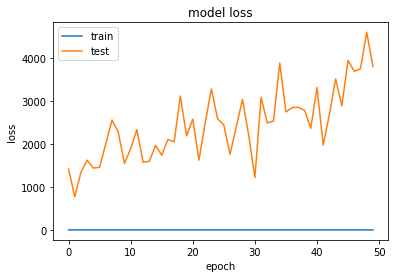

In [25]:
plot_hist(entirely_frozen_incepres_history, 'entirely_frozen_incepV3_rms')

#### saving the history of the fitting

In [26]:

with open(cwd + '/trainHistoryDict/basic_incepResnet_rms_history.p', 'wb') as file_pi:
        pickle.dump(entirely_frozen_incepres_history.history, file_pi)
print('history saved')

history saved


## Few layers unfrozen

#### loading model

In [0]:
base_incepRes = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepRes.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
few_unfrozen_incepRes_model = Model(inputs=base_incepRes.input, outputs=predictions)

In [30]:
for layer in base_incepRes.layers:
    print(layer.name)
    layer.trainable = False

input_2
conv2d_203
batch_normalization_203
activation_203
conv2d_204
batch_normalization_204
activation_204
conv2d_205
batch_normalization_205
activation_205
max_pooling2d_4
conv2d_206
batch_normalization_206
activation_206
conv2d_207
batch_normalization_207
activation_207
max_pooling2d_5
conv2d_211
batch_normalization_211
activation_211
conv2d_209
conv2d_212
batch_normalization_209
batch_normalization_212
activation_209
activation_212
average_pooling2d_1
conv2d_208
conv2d_210
conv2d_213
conv2d_214
batch_normalization_208
batch_normalization_210
batch_normalization_213
batch_normalization_214
activation_208
activation_210
activation_213
activation_214
mixed_5b
conv2d_218
batch_normalization_218
activation_218
conv2d_216
conv2d_219
batch_normalization_216
batch_normalization_219
activation_216
activation_219
conv2d_215
conv2d_217
conv2d_220
batch_normalization_215
batch_normalization_217
batch_normalization_220
activation_215
activation_217
activation_220
block35_1_mixed
block35_1_conv


#### calculating which layers to train

In [31]:
trainable_count = 0
per_layers = 0.2
num_model_layers = len(base_incepRes.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.2


#### setting layers to train

In [0]:
#few_unfrozen_incepv3_model.trainable = True


set_trainable = False
for idx, layer in enumerate(base_incepRes.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

#print('percent unfrozen:', trainable_count/ len(few_unfrozen_incepv3_model.layers) * 100 , '%')

In [33]:
for layer in few_unfrozen_incepRes_model.layers:
    print(layer.name,layer.trainable)

input_2 False
conv2d_203 False
batch_normalization_203 False
activation_203 False
conv2d_204 False
batch_normalization_204 False
activation_204 False
conv2d_205 False
batch_normalization_205 False
activation_205 False
max_pooling2d_4 False
conv2d_206 False
batch_normalization_206 False
activation_206 False
conv2d_207 False
batch_normalization_207 False
activation_207 False
max_pooling2d_5 False
conv2d_211 False
batch_normalization_211 False
activation_211 False
conv2d_209 False
conv2d_212 False
batch_normalization_209 False
batch_normalization_212 False
activation_209 False
activation_212 False
average_pooling2d_1 False
conv2d_208 False
conv2d_210 False
conv2d_213 False
conv2d_214 False
batch_normalization_208 False
batch_normalization_210 False
batch_normalization_213 False
batch_normalization_214 False
activation_208 False
activation_210 False
activation_213 False
activation_214 False
mixed_5b False
conv2d_218 False
batch_normalization_218 False
activation_218 False
conv2d_216 False


In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
few_unfrozen_incepRes_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [35]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'few_unfrozen_incepRes_rms.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
few_unfrozen_incepRes_history = few_unfrozen_incepRes_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 32s 1s/step - loss: 0.6857 - accuracy: 0.6740 - val_loss: 4889.0560 - val_accuracy: 0.3722
Epoch 2/50
24/24 [==============================] - 18s 759ms/step - loss: 0.5193 - accuracy: 0.7646 - val_loss: 7722.3175 - val_accuracy: 0.3722
Epoch 3/50
24/24 [==============================] - 18s 765ms/step - loss: 0.4118 - accuracy: 0.8257 - val_loss: 5696.8786 - val_accuracy: 0.3722
Epoch 4/50
24/24 [==============================] - 20s 836ms/step - loss: 0.2575 - accuracy: 0.8972 - val_loss: 8982.4089 - val_accuracy: 0.3722
Epoch 5/50
24/24 [==============================] - 20s 824ms/step - loss: 0.1803 - accuracy: 0.9309 - val_loss: 12246.3164 - val_accuracy: 0.3722
Epoch 6/50
24/24 [==============================] - 18s 763ms/step - loss: 0.1156 - accuracy: 0.9549 - val_loss: 6787.2549 - val_accuracy: 0.3722
Epoch 7/50
24/24 [==============================] - 20s 

#### testing the model

In [36]:
test_steps = int(len(df_test)/batch_size)

metrics = few_unfrozen_incepRes_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 494ms/step - loss: 15386.5980 - accuracy: 0.3417
model accuracy: 0.34166667


#### plotting training

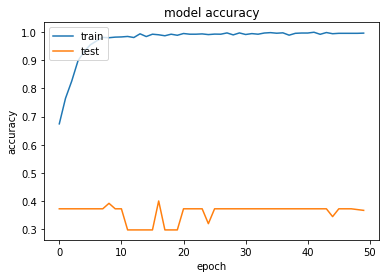

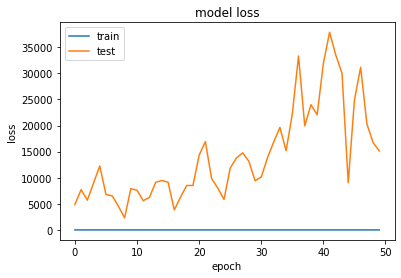

In [37]:
plot_hist(few_unfrozen_incepRes_history, 'few_unfrozen_incepRes_rms')

#### saving the history of the fitting

In [38]:
with open(cwd + '/trainHistoryDict/few_unfrozen_incepRes_rms_history.p', 'wb') as file_pi:
        pickle.dump(few_unfrozen_incepRes_history.history, file_pi)
print('history saved')

history saved


## Many layers unfrozen

#### loading model

In [0]:
base_incepRes = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepRes.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
many_unfrozen_incepRes_model = Model(inputs=base_incepRes.input, outputs=predictions)

In [42]:
for layer in base_incepRes.layers:
    print(layer.name)
    layer.trainable = False

input_3
conv2d_406
batch_normalization_406
activation_406
conv2d_407
batch_normalization_407
activation_407
conv2d_408
batch_normalization_408
activation_408
max_pooling2d_8
conv2d_409
batch_normalization_409
activation_409
conv2d_410
batch_normalization_410
activation_410
max_pooling2d_9
conv2d_414
batch_normalization_414
activation_414
conv2d_412
conv2d_415
batch_normalization_412
batch_normalization_415
activation_412
activation_415
average_pooling2d_2
conv2d_411
conv2d_413
conv2d_416
conv2d_417
batch_normalization_411
batch_normalization_413
batch_normalization_416
batch_normalization_417
activation_411
activation_413
activation_416
activation_417
mixed_5b
conv2d_421
batch_normalization_421
activation_421
conv2d_419
conv2d_422
batch_normalization_419
batch_normalization_422
activation_419
activation_422
conv2d_418
conv2d_420
conv2d_423
batch_normalization_418
batch_normalization_420
batch_normalization_423
activation_418
activation_420
activation_423
block35_1_mixed
block35_1_conv


#### calculating which layers to train

In [43]:
trainable_count = 0
per_layers = 0.7
num_model_layers = len(base_incepRes.layers)
starting_layer = int( num_model_layers * (1 - per_layers))
true_per_trained = (num_model_layers - starting_layer) / num_model_layers


print('true percentage of model trainable:', true_per_trained)

true percentage of model trainable: 0.7


#### setting which layers to train

In [0]:
set_trainable = False
for idx, layer in enumerate(base_incepRes.layers):
    if idx == starting_layer:
        set_trainable = True
    if set_trainable:
        layer.trainable = True
        trainable_count += 1
    else:
        layer.trainable = False

In [45]:
for layer in many_unfrozen_incepRes_model.layers:
    print(layer.name,layer.trainable)

input_3 False
conv2d_406 False
batch_normalization_406 False
activation_406 False
conv2d_407 False
batch_normalization_407 False
activation_407 False
conv2d_408 False
batch_normalization_408 False
activation_408 False
max_pooling2d_8 False
conv2d_409 False
batch_normalization_409 False
activation_409 False
conv2d_410 False
batch_normalization_410 False
activation_410 False
max_pooling2d_9 False
conv2d_414 False
batch_normalization_414 False
activation_414 False
conv2d_412 False
conv2d_415 False
batch_normalization_412 False
batch_normalization_415 False
activation_412 False
activation_415 False
average_pooling2d_2 False
conv2d_411 False
conv2d_413 False
conv2d_416 False
conv2d_417 False
batch_normalization_411 False
batch_normalization_413 False
batch_normalization_416 False
batch_normalization_417 False
activation_411 False
activation_413 False
activation_416 False
activation_417 False
mixed_5b False
conv2d_421 False
batch_normalization_421 False
activation_421 False
conv2d_419 False


In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
many_unfrozen_incepRes_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [47]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'many_unfrozen_incepRes_rms.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
many_unfrozen_incepRes_history = many_unfrozen_incepRes_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 52s 2s/step - loss: 0.6722 - accuracy: 0.6910 - val_loss: 3525.0187 - val_accuracy: 0.3722
Epoch 2/50
24/24 [==============================] - 29s 1s/step - loss: 0.4842 - accuracy: 0.7799 - val_loss: 5531.6932 - val_accuracy: 0.3722
Epoch 3/50
24/24 [==============================] - 30s 1s/step - loss: 0.3707 - accuracy: 0.8295 - val_loss: 2254.1058 - val_accuracy: 0.3722
Epoch 4/50
24/24 [==============================] - 30s 1s/step - loss: 0.2600 - accuracy: 0.8910 - val_loss: 3494.0472 - val_accuracy: 0.3722
Epoch 5/50
24/24 [==============================] - 30s 1s/step - loss: 0.1809 - accuracy: 0.9236 - val_loss: 4696.1452 - val_accuracy: 0.3722
Epoch 6/50
24/24 [==============================] - 30s 1s/step - loss: 0.1265 - accuracy: 0.9531 - val_loss: 2379.3543 - val_accuracy: 0.3722
Epoch 7/50
24/24 [==============================] - 30s 1s/step - loss: 

#### testing the model

In [48]:
test_steps = int(len(df_test)/batch_size)

metrics = many_unfrozen_incepRes_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 482ms/step - loss: 65169.1784 - accuracy: 0.3444
model accuracy: 0.34444445


#### plotting training

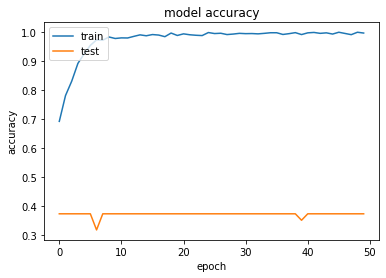

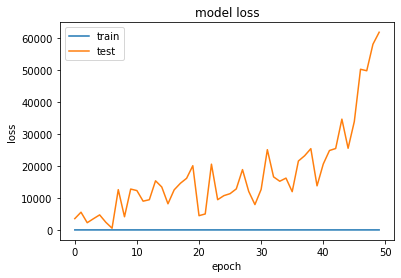

In [49]:
plot_hist(many_unfrozen_incepRes_history, 'many_unfrozen_incepRes_rms')

#### saving the history of the fitting

In [50]:
with open(cwd + '/trainHistoryDict/many_unfrozen_incepRes_rms_history.p', 'wb') as file_pi:
        pickle.dump(many_unfrozen_incepRes_history.history, file_pi)
print('history saved')

history saved


## entirely unfrozen

In [0]:
base_incepRes = tf.keras.applications.inception_resnet_v2.InceptionResNetV2(weights='imagenet', include_top=False, input_shape=(200, 200, 3),pooling=None)

#### modifying slightly

In [0]:
# add a global spatial average pooling layer
x = base_incepRes.output

x = GlobalAveragePooling2D()(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# let's add a fully-connected layer
x = Dense(512, activation='relu')(x)

x = Dropout(0.3)(x)

# and a logits layer -- let's say we have 3 classes
predictions = Dense(3, activation='softmax')(x)

#### creating model object

In [0]:
# this is the model we will train
unfrozen_incepRes_model = Model(inputs=base_incepRes.input, outputs=predictions)

In [54]:
for layer in unfrozen_incepRes_model.layers:
    print(layer.name)
    layer.trainable = True

input_4
conv2d_609
batch_normalization_609
activation_609
conv2d_610
batch_normalization_610
activation_610
conv2d_611
batch_normalization_611
activation_611
max_pooling2d_12
conv2d_612
batch_normalization_612
activation_612
conv2d_613
batch_normalization_613
activation_613
max_pooling2d_13
conv2d_617
batch_normalization_617
activation_617
conv2d_615
conv2d_618
batch_normalization_615
batch_normalization_618
activation_615
activation_618
average_pooling2d_3
conv2d_614
conv2d_616
conv2d_619
conv2d_620
batch_normalization_614
batch_normalization_616
batch_normalization_619
batch_normalization_620
activation_614
activation_616
activation_619
activation_620
mixed_5b
conv2d_624
batch_normalization_624
activation_624
conv2d_622
conv2d_625
batch_normalization_622
batch_normalization_625
activation_622
activation_625
conv2d_621
conv2d_623
conv2d_626
batch_normalization_621
batch_normalization_623
batch_normalization_626
activation_621
activation_623
activation_626
block35_1_mixed
block35_1_con

In [55]:
for layer in unfrozen_incepRes_model.layers:
    print(layer.name,' Trainable =',layer.trainable)

input_4  Trainable = True
conv2d_609  Trainable = True
batch_normalization_609  Trainable = True
activation_609  Trainable = True
conv2d_610  Trainable = True
batch_normalization_610  Trainable = True
activation_610  Trainable = True
conv2d_611  Trainable = True
batch_normalization_611  Trainable = True
activation_611  Trainable = True
max_pooling2d_12  Trainable = True
conv2d_612  Trainable = True
batch_normalization_612  Trainable = True
activation_612  Trainable = True
conv2d_613  Trainable = True
batch_normalization_613  Trainable = True
activation_613  Trainable = True
max_pooling2d_13  Trainable = True
conv2d_617  Trainable = True
batch_normalization_617  Trainable = True
activation_617  Trainable = True
conv2d_615  Trainable = True
conv2d_618  Trainable = True
batch_normalization_615  Trainable = True
batch_normalization_618  Trainable = True
activation_615  Trainable = True
activation_618  Trainable = True
average_pooling2d_3  Trainable = True
conv2d_614  Trainable = True
conv2

#### setting the optimizer

In [0]:
opt = tf.keras.optimizers.RMSprop(lr=1e-4)
# compile the model (should be done *after* setting layers to non-trainable)
unfrozen_incepRes_model.compile(optimizer=opt, loss='categorical_crossentropy',metrics=['accuracy'])

#### fitting the model

In [57]:
train_steps = int(len(df_train)/batch_size) #total trains set / batch_size
val_steps = int(len(df_val)/batch_size)

print('train steps:',train_steps)
print('val steps:',val_steps)

epochs = 50


model_filepath = 'unfrozen_incepRes_rms.h5'
mcp = ModelCheckpoint(model_filepath, monitor='accuracy', save_best_only=True, mode='max')

# Train the model with validation 
unfrozen_incepRes_history = unfrozen_incepRes_model.fit( train_dataset, steps_per_epoch = train_steps,
                   epochs = epochs,
                   validation_data = valid_dataset,
                   validation_steps = val_steps,
                   callbacks=[mcp])

train steps: 24
val steps: 3
Train for 24 steps, validate for 3 steps
Epoch 1/50
24/24 [==============================] - 66s 3s/step - loss: 0.6948 - accuracy: 0.6788 - val_loss: 0.9594 - val_accuracy: 0.5194
Epoch 2/50
24/24 [==============================] - 36s 2s/step - loss: 0.5165 - accuracy: 0.7653 - val_loss: 0.9600 - val_accuracy: 0.5528
Epoch 3/50
24/24 [==============================] - 36s 1s/step - loss: 0.4012 - accuracy: 0.8222 - val_loss: 2.0548 - val_accuracy: 0.3861
Epoch 4/50
24/24 [==============================] - 36s 1s/step - loss: 0.2746 - accuracy: 0.8774 - val_loss: 2.6916 - val_accuracy: 0.3639
Epoch 5/50
24/24 [==============================] - 36s 1s/step - loss: 0.1887 - accuracy: 0.9219 - val_loss: 3.7102 - val_accuracy: 0.3694
Epoch 6/50
24/24 [==============================] - 36s 1s/step - loss: 0.1386 - accuracy: 0.9493 - val_loss: 2.8122 - val_accuracy: 0.3861
Epoch 7/50
24/24 [==============================] - 36s 2s/step - loss: 0.1075 - accuracy:

#### testing the model

In [58]:
test_steps = int(len(df_test)/batch_size)

metrics = unfrozen_incepRes_model.evaluate(test_dataset,
                   steps = test_steps)
print("model accuracy:",metrics[1])

3/3 [==============================] - 1s 492ms/step - loss: 3.2945 - accuracy: 0.7278
model accuracy: 0.7277778


#### plotting training

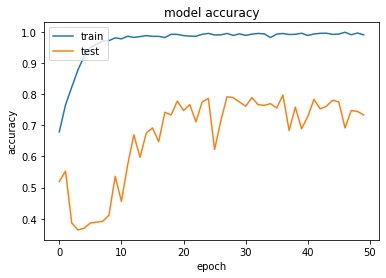

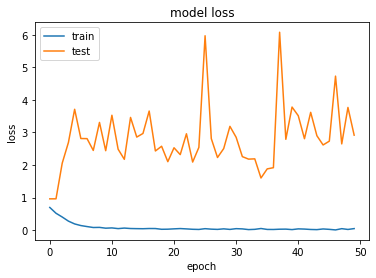

In [59]:
plot_hist(unfrozen_incepRes_history, 'unfrozen_incepRes_rms')

#### saving the history of the fitting

In [60]:
with open(cwd + '/trainHistoryDict/unfrozen_incepRes_rms_history.p', 'wb') as file_pi:
        pickle.dump(unfrozen_incepRes_history.history, file_pi)
print('history saved')

history saved
